In [1]:
from pathlib import Path
import requests

In [2]:
dataPath = Path('data')
Path = dataPath/'mnist'

Path.mkdir(parents=True, exist_ok=True)

In [3]:
url = "http://deeplearning.net/data/mnist/"
filename = "mnist.pkl.gz"

In [4]:
if not (Path/filename).exists():
    content = requests.get(url+filename).content
    (Path / filename).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [5]:
import pickle
import gzip

In [6]:
with gzip.open((Path/filename).as_posix(), 'rb') as file:
    ((xTrain, yTrain), (xValid, yValid), _) = pickle.load(file, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

In [7]:
from matplotlib import pyplot
import numpy as np

(50000, 784)


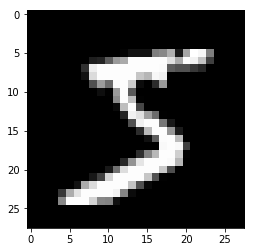

In [8]:
pyplot.imshow(xTrain[0].reshape((28, 28)), cmap='gray')
print(xTrain.shape)

In [9]:
import torch

In [10]:
xTrain, yTrain, xValid, yValid = map(torch.tensor, (xTrain, yTrain, xValid, yValid))

In [11]:
n, c = xTrain.shape

## Neural net from scratch (no torch.nn)

We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n))

In [12]:
import math

In [13]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [14]:
def logSoftmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return logSoftmax(xb @ weights + bias)

In [15]:
bs = 64
xb = xTrain[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4168, -2.6964, -2.4408, -2.4027, -2.3114, -2.1267, -2.5013, -2.6738,
        -1.6352, -2.2873], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [16]:
def negativeLogLikelihood(input, target):
    return -input[range(target.shape[0]), target].mean()

In [17]:
lossFunc = negativeLogLikelihood

In [18]:
yb = yTrain[0:bs]
print(lossFunc(preds, yb))

tensor(2.4133, grad_fn=<NegBackward>)


In [19]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [36]:
print(accuracy(preds, yb))

RuntimeError: The size of tensor a (64) must match the size of tensor b (16) at non-singleton dimension 0

We can now run a training loop. For each iteration, we will:

· select a mini-batch of data (of size bs)
· use the model to make predictions
· calculate the loss
· loss.backward() updates the gradients of the model, in this case, weights and bias.

In [21]:
from IPython.core.debugger import set_trace

In [22]:
lr = 0.5
epochs = 2

In [23]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
#         set_trace()
        start = i * bs
        end = start + bs
        xb = xTrain[start:end]
        yb = yTrain[start:end]
        pred = model(xb)
        loss = lossFunc(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [24]:
print(lossFunc(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0825, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

In [25]:
import torch.nn.functional as F

In [26]:
lossFunc = F.cross_entropy

In [27]:
def model(xb):
    return xb @ weights + bias

In [28]:
print(lossFunc(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

In [29]:
from torch import nn

In [30]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [31]:
model = MnistLogistic()

In [32]:
print(lossFunc(model(xb), yb))

tensor(2.3459, grad_fn=<NllLossBackward>)


In [33]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start = i * bs
            end = start + bs
            xb = xTrain[start:end]
            yb = yTrain[start:end]
            pred = model(xb)
            loss = lossFunc(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [34]:
fit()

In [35]:
print(lossFunc(model(xb), yb))

tensor(0.0831, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [40]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

In [41]:
model = MnistLogistic()

In [42]:
print(lossFunc(model(xb), yb))

tensor(2.3617, grad_fn=<NllLossBackward>)


In [43]:
fit()

In [44]:
print(lossFunc(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward>)
